# Download image data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

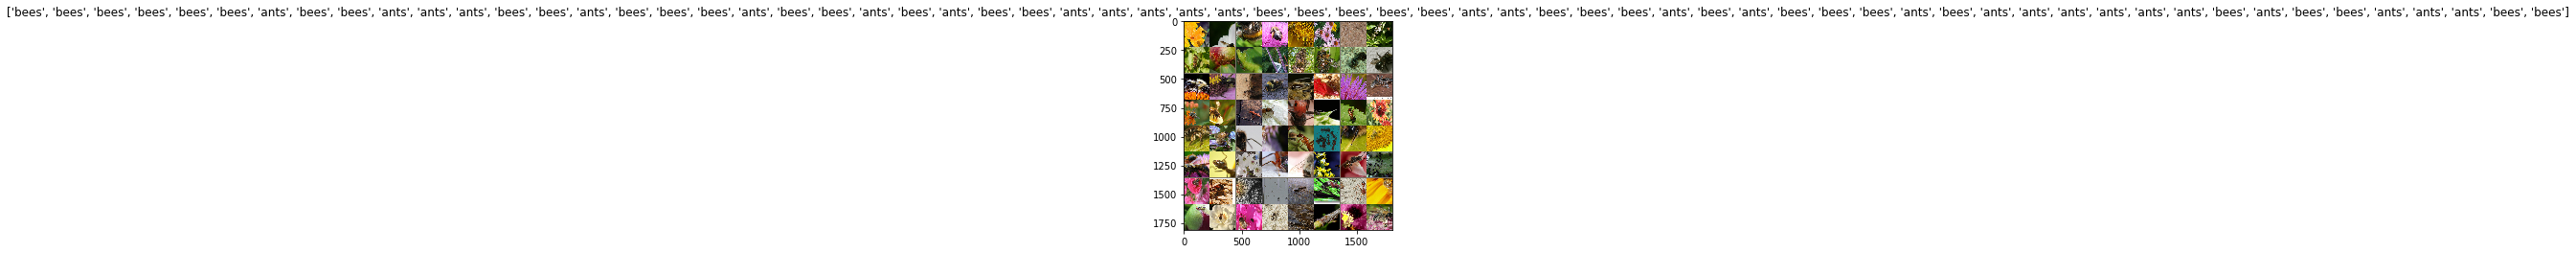

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                # the same as model.train(False)
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs = Variable(inputs)
                    labels = Variable(labels)
            
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            print()
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
        
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0116 Acc: 0.5574

val Loss: 0.0142 Acc: 0.5425

Epoch 1/24
----------
train Loss: 0.0093 Acc: 0.7254

val Loss: 0.0104 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.0082 Acc: 0.8156

val Loss: 0.0076 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.0061 Acc: 0.9016

val Loss: 0.0065 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.0051 Acc: 0.8934

val Loss: 0.0049 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.0038 Acc: 0.9262

val Loss: 0.0042 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.0034 Acc: 0.9426

val Loss: 0.0044 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.0036 Acc: 0.9180

val Loss: 0.0044 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0039 Acc: 0.9057

val Loss: 0.0045 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0027 Acc: 0.9590

val Loss: 0.0039 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0031 Acc: 0.9590

val Loss: 0.0038 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0033 Acc: 0.9426

val Loss: 0.0040 Acc

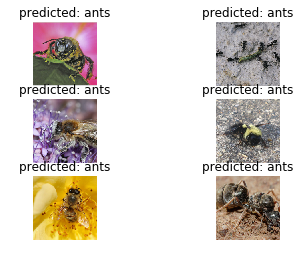

In [7]:
visualize_model(model_ft)


# fixed feature extractor

In [8]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.0221 Acc: 0.5656

val Loss: 0.0200 Acc: 0.5621

Epoch 1/24
----------
train Loss: 0.0163 Acc: 0.7951

val Loss: 0.0118 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.0116 Acc: 0.9057

val Loss: 0.0097 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.0083 Acc: 0.9508

val Loss: 0.0073 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.0078 Acc: 0.9344

val Loss: 0.0068 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.0071 Acc: 0.9344

val Loss: 0.0061 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.0069 Acc: 0.9385

val Loss: 0.0061 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.0075 Acc: 0.9180

val Loss: 0.0058 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0067 Acc: 0.9467

val Loss: 0.0059 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0058 Acc: 0.9508

val Loss: 0.0058 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0053 Acc: 0.9754

val Loss: 0.0059 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0065 Acc: 0.9426

val Loss: 0.0059 Acc

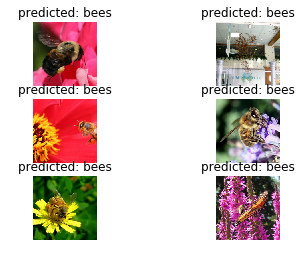

In [10]:
visualize_model(model_conv)
